# Preprocessing
This notebook is used to preprocess the data from the two datasets and load it all into a single file per dataset, containing univariate time series. The models will have to forecast 5 timesteps into the future
## Weather data
**-99 if no data**

In [1]:
from glob import glob
import pandas as pd
import traceback
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm

In [2]:
PREDICTION_STEP=5

In [3]:
places = []
data_series = []
DEBUG = False

for file in glob("../Dataset/weather_cities/*"):
    if file.endswith(".LOG"): continue # Don't process the log file
    place = file[file.find("\\")+1:file.find('.')] # store name of city
    with open(file, "r") as f:
        try:
            series = {}
            for line in f.readlines():
                sep_data = line.strip().split()
                date = "-".join(sep_data[:3])
                if len(sep_data[2]) < 4: continue
                if date[:3] == "3-0": # Takes care of 3-0-YYYY date which means 2-29-YYYY (may happen in a leap year)
                    date = "2-29" + date[3:]
                weather = float(sep_data[-1])
                if weather != -99: series[date] = weather
            weather_series = pd.Series(series)
            weather_series.index = pd.DatetimeIndex(weather_series.index)
            weather_series.sort_index(inplace=True)
            weather_series.name = place      
        except:
            traceback.print_exc()
            print(place, " ", line)

    data_series.append(weather_series)

In [4]:
# Count data per day
# First we have to unify all the series into a dataframe
weather_df = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), data_series)

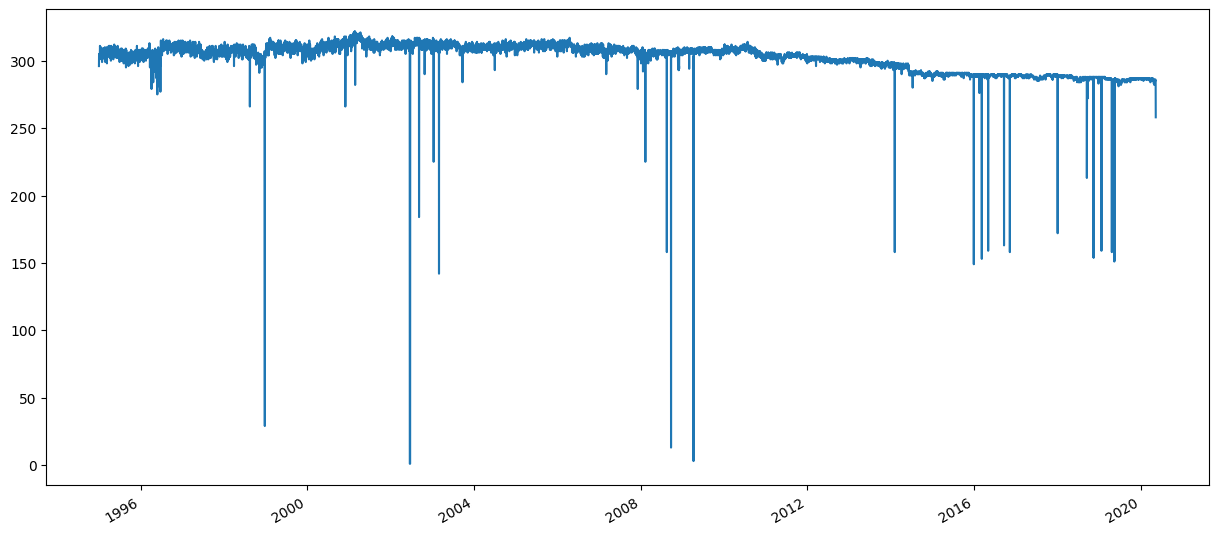

In [5]:
weather_df.T.count().plot(figsize=(15,7))
plt.show()

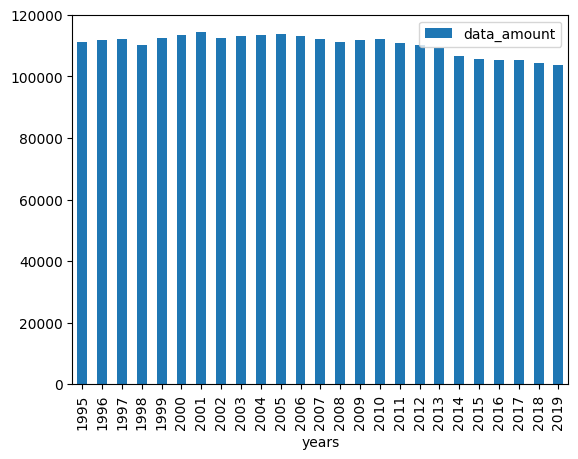

In [6]:
# Amount of data per year
years = []
data_amount = []
for year in range(weather_df.index.min().year, weather_df.index.max().year):
    data_amount.append(weather_df[f"{year}-01-01":f"{year}-12-31"].T.count().sum())
    years.append(year)

data_per_year = pd.DataFrame({"years":years, "data_amount":data_amount}).set_index("years")

data_per_year.plot(kind='bar')
plt.show()

In [7]:
#Year with maximum amount of data
data_per_year.data_amount.idxmax()

2001

The year with the maximum amount of data is 2001, so this will be our training data from now on. We will take data starting in 1999 to have each month come up 3 times at least.

In [8]:
train_data = weather_df["1999-01-01":"2001-12-31"]

In [9]:
# Forward fill and backfill
train_data = train_data.ffill().bfill()

In [10]:
# Drop citys that have no data even after backfilling and forwardfilling
train_data.drop(labels=train_data.T.iloc[(train_data.isna().sum() > 0).values].index, axis=1, inplace=True)

In [11]:
train_data.isna().sum().sum() # No missing data

0

In [12]:
train_data = train_data.groupby(train_data.index.to_period("M")).mean() # Group by month

<AxesSubplot: >

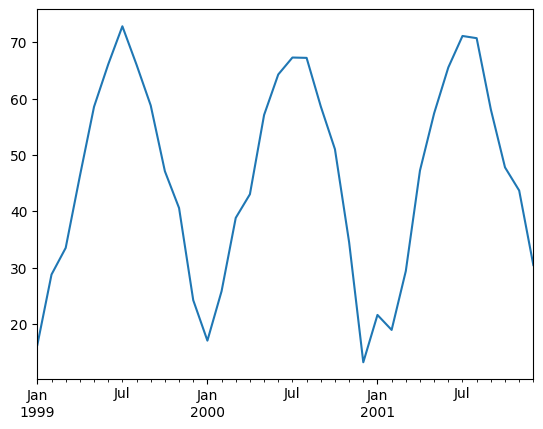

In [13]:
# Example of TS
train_data.T.loc["WIGREBAY"].plot()

## Data composition


In [14]:
X, y = train_data.iloc[:-PREDICTION_STEP].T, train_data.iloc[-PREDICTION_STEP:].T

The last PEDICTION_STEP datapoints serve as the test set labels.

In [15]:
X.to_pickle('../Dataset/preprocessed/weather/X.pkl')
y.to_pickle('../Dataset/preprocessed/weather/y.pkl')

## Product demand data

In [16]:
demand_df = pd.read_csv('../Dataset/Historical Product Demand.csv', parse_dates = [4], infer_datetime_format=True)

In [17]:
demand_df.Order_Demand = demand_df.Order_Demand.apply(lambda x: x.replace('(', '').replace(')', '')).astype('int32') # Demand formatting to get rid of parentheses

In [18]:
demand_df.Date = pd.to_datetime(demand_df.Date) # Convert to datetime

In [19]:
n_products = len(demand_df.Product_Code.unique())

print(f"There are {n_products} unique products in the dataset.")

There are 2160 unique products in the dataset.


In [20]:
product_ids = demand_df.Product_Code.unique()
product_ids.sort()

In [21]:
train_df = None
for pid in tqdm(product_ids):
    product_data = demand_df[demand_df.Product_Code == pid]
    product_data.index = product_data.Date
    product_data = product_data.drop(['Product_Code', 'Warehouse', 'Product_Category', 'Date'], axis=1)
    product_data.sort_index(inplace=True)
    product_data.columns = [pid]
    product_data = product_data.groupby(product_data.index.date).sum()

    if train_df is not None: train_df = train_df.merge(product_data, left_index=True, right_index=True, how='outer')
    else: train_df = product_data

  0%|          | 5/2160 [00:00<03:14, 11.08it/s]


KeyboardInterrupt: 

In [ ]:
train_df.index =  pd.to_datetime(train_df.index)

In [ ]:
DEMAND_TRAIN_DF_FILE = '../Dataset/preprocessed/demand/all.pkl'
# train_df = train_df.T
# train_df.to_pickle(DEMAND_TRAIN_DF_FILE)
train_df = pd.read_pickle(DEMAND_TRAIN_DF_FILE)

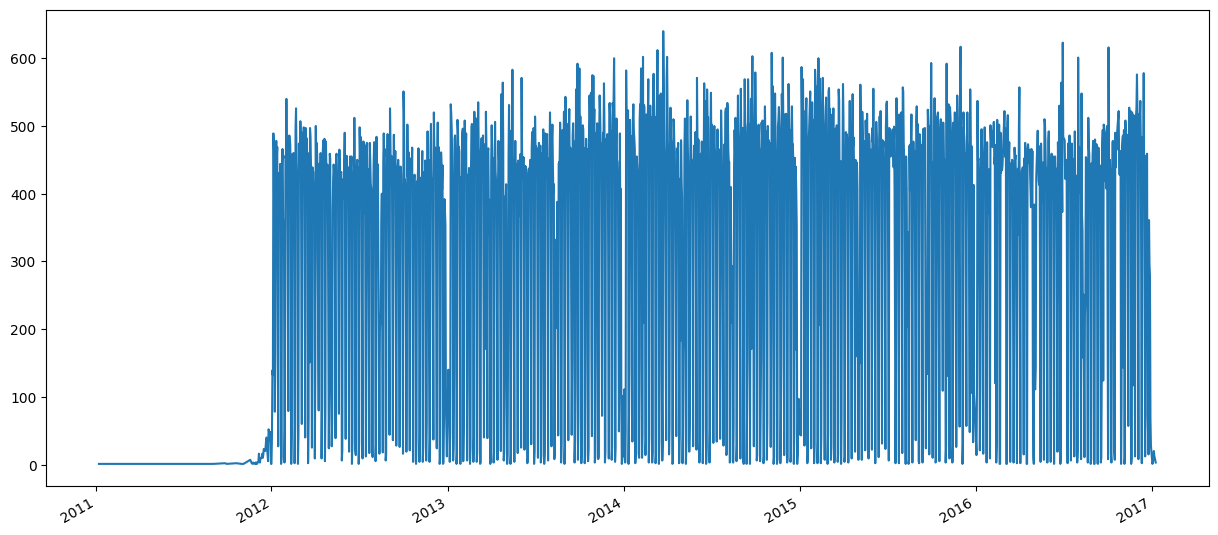

In [ ]:
train_df.count().plot(figsize=(15,7))
plt.show()

<AxesSubplot: >

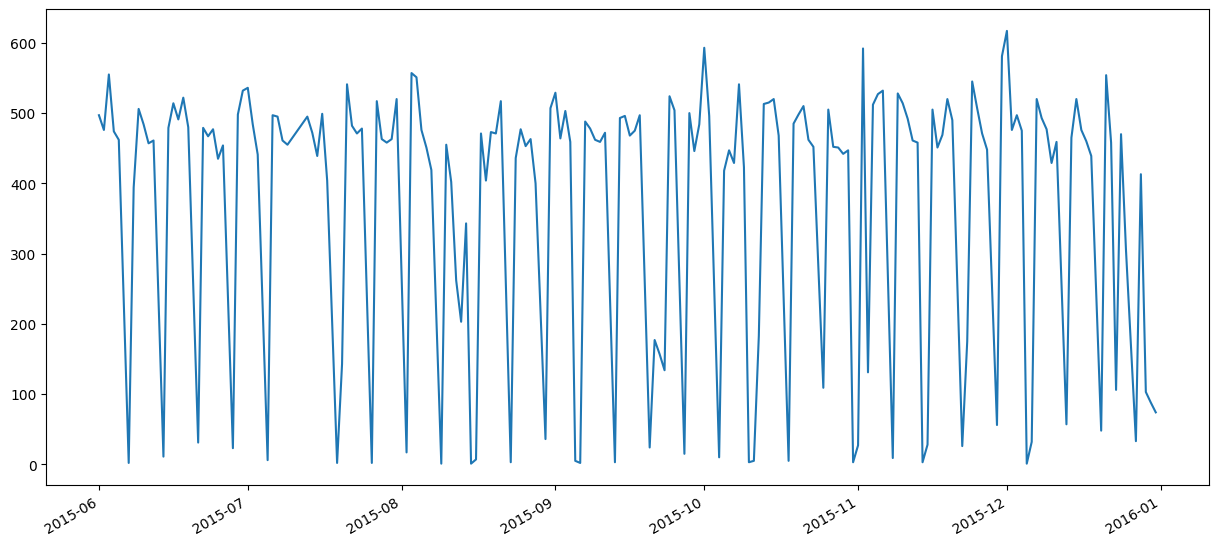

In [ ]:
train_df.T["2015-06-01":"2015-12-31"].T.count().plot(figsize=(15,7))

The days that have a exceptionally low demand are sundays. I will group the data by month.

In [ ]:
train_df = train_df.T

In [ ]:
train_df.index = pd.to_datetime(train_df.index)

In [ ]:
train_df = train_df["2012-01-01":"2016-10-31"]

In [ ]:
X = train_df.groupby(train_df.index.to_period("M")).sum().T

In [ ]:
X, y = X.T.iloc[:-PREDICTION_STEP].T, X.T.iloc[-PREDICTION_STEP:].T

In [ ]:
X.to_pickle('../Dataset/preprocessed/demand/X.pkl')
y.to_pickle('../Dataset/preprocessed/demand/y.pkl')